In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

: 

In [2]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from scipy.signal import correlate2d
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.signal import correlate

# Contoh membaca file .mat
#data = sio.loadmat("BG450_model.mat")
data = np.loadtxt('../initial_model.txt')
#print(data.keys())
# Misalkan velocity model ada di key tertentu, misalnya 'velocity_model':
vp = data   #['v'].T[100:300]
#vp0 = gaussian_filter(vp, 3) #velocity model intial

print(np.min(vp))
print(np.max(vp))

vp.shape

dict_keys(['__header__', '__version__', '__globals__', 'v', 'n', 'd', 'o'])
1.4493544101715088
4.720361709594727


(200, 205)

In [3]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu May 22 10:15:50 2014',
 '__version__': '1.0',
 '__globals__': [],
 'v': array([[1.46356058, 1.46638119, 1.48230541, ..., 1.49039567, 1.46701777,
         1.45383   ],
        [1.46647811, 1.47416615, 1.48770535, ..., 1.49200451, 1.47077906,
         1.45204437],
        [1.45675921, 1.47178292, 1.48595953, ..., 1.49092162, 1.46984661,
         1.44722259],
        ...,
        [4.09731007, 4.09630251, 4.09983778, ..., 3.99882603, 3.98956394,
         3.98412228],
        [4.13336897, 4.13244724, 4.13520861, ..., 4.06025696, 4.04679441,
         4.03740788],
        [4.15405846, 4.15371513, 4.15621567, ..., 4.11098623, 4.09505844,
         4.0832634 ]]),
 'n': array([[205, 451]], dtype=uint16),
 'd': array([[10, 10]], dtype=uint8),
 'o': array([[0, 0]], dtype=uint8)}

In [4]:
nshots = 11  # Number of shots to create gradient from
nreceivers = 120  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

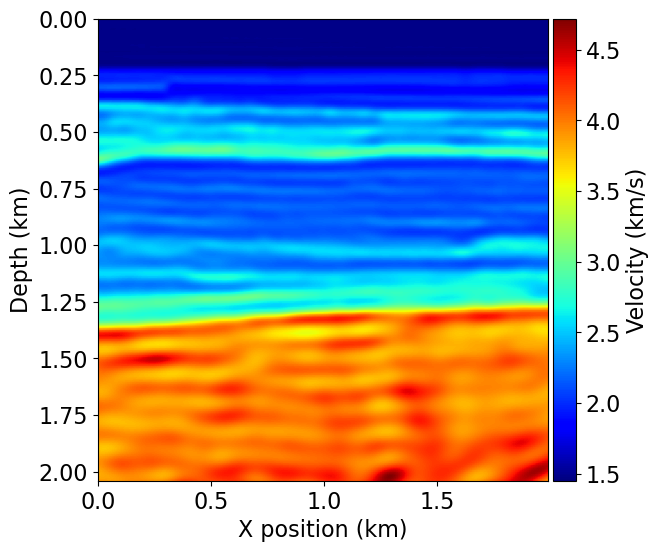

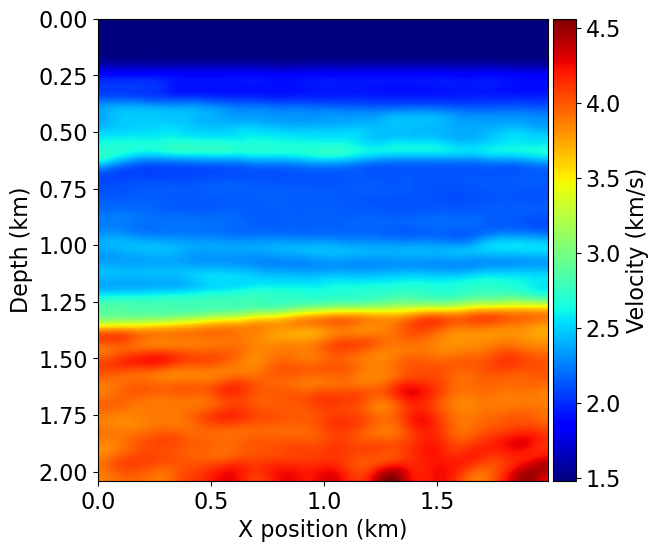

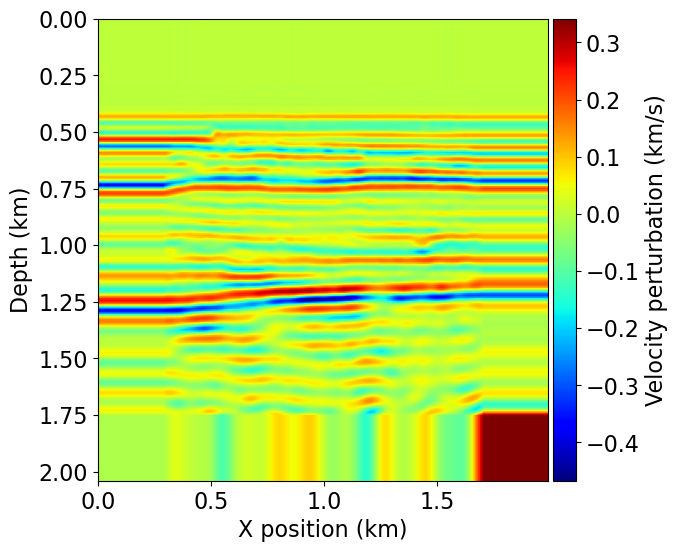

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity, plot_perturbation, Receiver

# Define a physical size
shape = (vp.shape)  # Number of grid point (nx, nz)
spacing = (10, 10)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0.,0.)  # What is the location of the top left corner. This is necessary to define
nboundary = 40

model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp")

model0 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)



plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

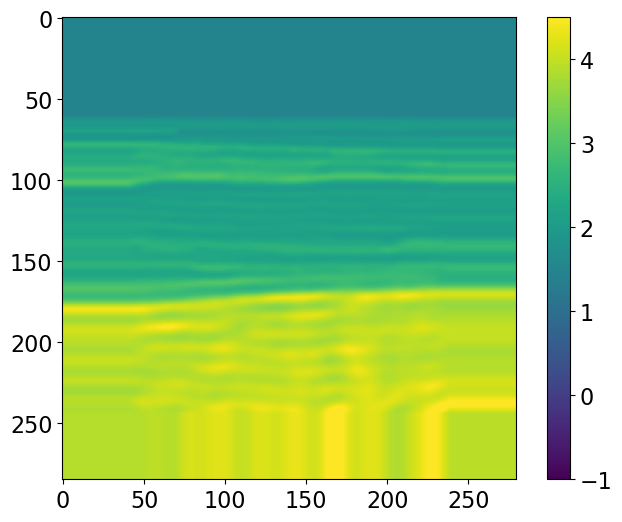

In [ ]:
plt.imshow(model.vp.data.T)
plt.colorbar()
plt.show()


In [12]:
print(np.min(model.vp.data))

1.4493544


In [106]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry, TimeAxis, RickerSource, PointSource, WaveletSource

t0 = 0.
tn = 1600. 
dt = model.critical_dt
time = TimeAxis(start=t0, stop=tn, step=dt)


f0 = 0.010

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((nshots, 2))
src_coordinates[:, 0] = np.linspace(605, 1405, nshots)
src_coordinates[:, 1] = 20.  # Depth is 20m


In [107]:
geometrys = []

for i in range(nshots):
    # Define acquisition geometry: receivers

    # Initialize receivers for synthetic and imaging data
    rec_coordinates = np.empty((nreceivers, 2))
    rec_coordinates[:, 0] = np.linspace(10+(i*80), 1200+(i*80), nreceivers)
    rec_coordinates[:, 1] = 10.  # Depth is 20m

    # Geometry
    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
    geometrys.append(geometry)

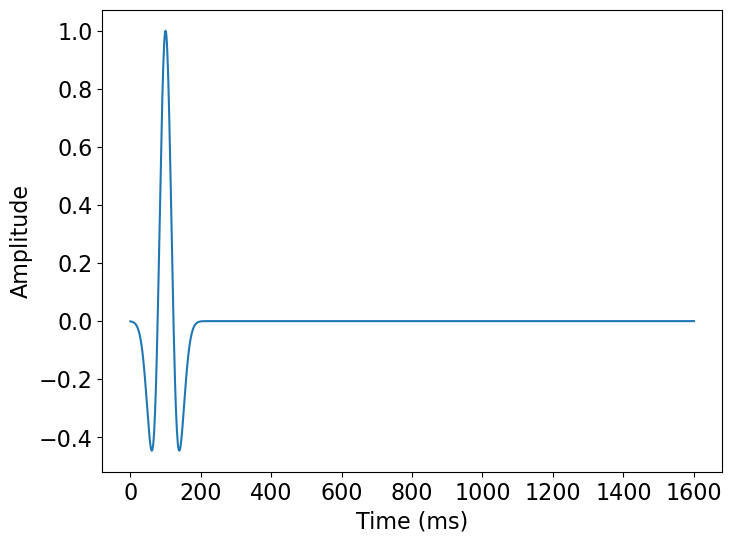

(1235, 1)

In [108]:
srct = []

for i in range(nshots):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time)
    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = src_coordinates[i, 0]
    src.coordinates.data[0, -1] = 20.  # Depth is 20m
    #src.data[:] *= -1
    srct.append(src)
srct[0].show()
srct[0].data.shape

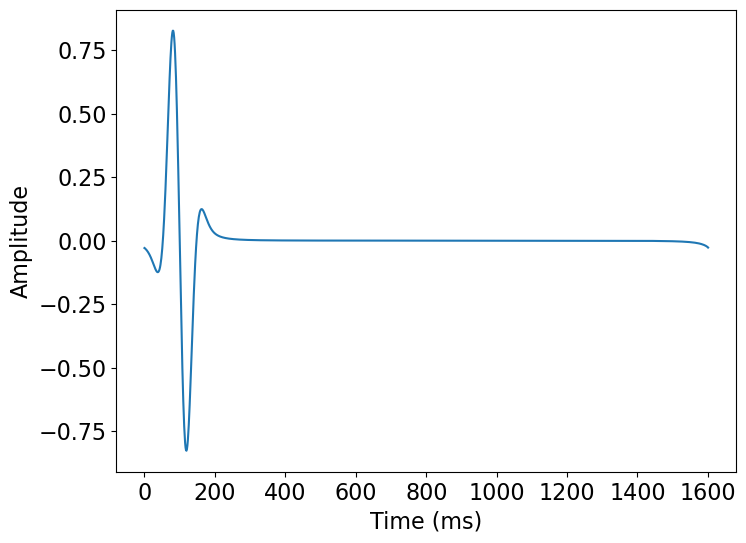

In [109]:
t = np.arange(t0, tn+dt, (dt))
t = t/1000
f0z = f0*1000
t0 = (1/f0z)
st = (1 - (2*(np.pi**2)*(f0z**2)*(t-t0)**2))*(np.exp(-1*(np.pi**2)*(f0z**2)*(t-t0)**2))

wavelet = st

angle = 90
shifted = np.real(np.exp(1j*np.radians(angle)) * signal.hilbert(wavelet))
shifted = np.array([shifted])
shiftedT = shifted.T

srcs = []

for i in range(nshots):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time)
    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = src_coordinates[i, 0]
    src.coordinates.data[0, -1] = 20.  # Depth is 20m
    src.data[:] = shiftedT
    srcs.append(src)
srcs[0].show()

In [110]:
geometry.src_positions[2,:]

array([765.,  20.])

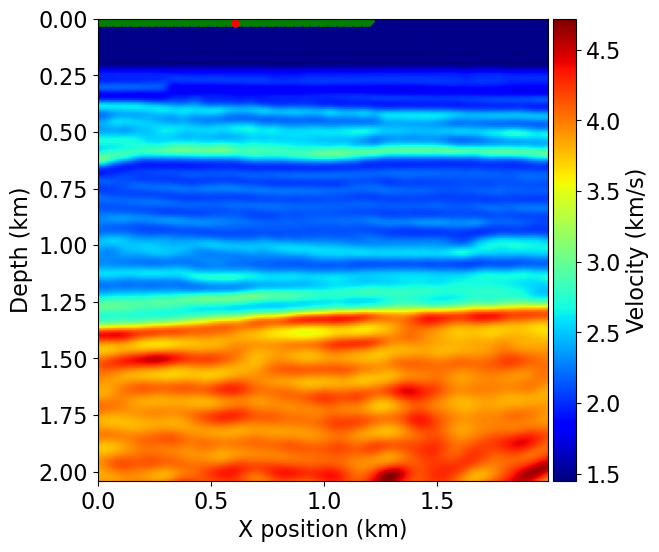

In [111]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=srct[0].coordinates.data,
              receiver=geometrys[0].rec_positions)

In [112]:
print(srct[0].coordinates.data)

[[605.  20.]]


In [113]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

recs = []

for i in range(nshots):
    solver = AcousticWaveSolver(model, geometrys[i], space_order=2)
    rec = Receiver(name='rec', grid=model.grid, time_range=geometrys[i].time_axis, coordinates=geometrys[i].rec_positions)
    _, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=rec)
    recs.append(rec)
    
    

In [42]:
print(model.grid)

Grid[extent=(3590, 3640), shape=(360, 365), dimensions=(x, y)]


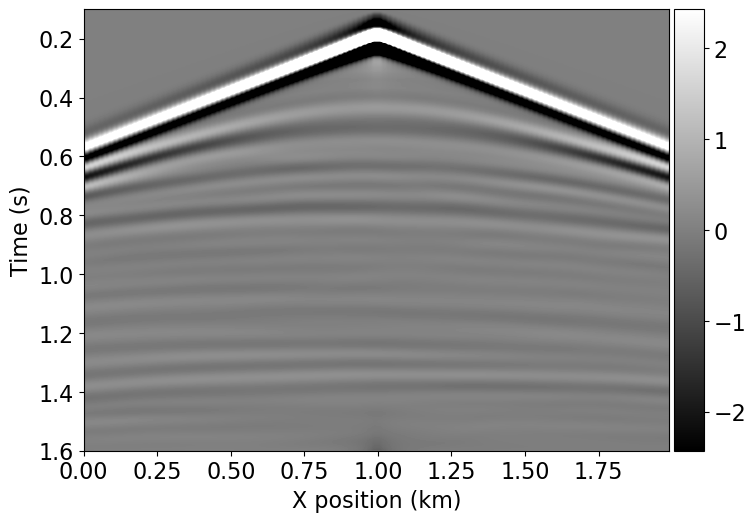

In [79]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(recs[0].data, model, t0, tn)

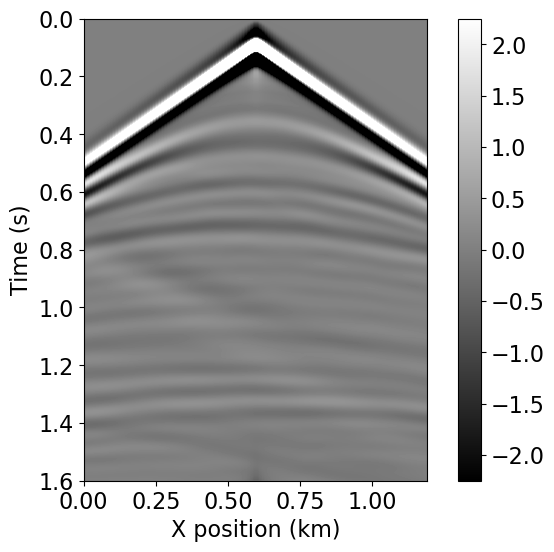

In [114]:
#recs[0].data.shape

plt.imshow(recs[0].data, extent=[0, 1.19, 1.6, 0], cmap="gray", vmin=-2.25, vmax=2.25)
plt.xlabel('X position (km)')
plt.ylabel('Time (s)')
plt.colorbar()
plt.show()

In [16]:
for i in range(len(recs)):
    matrix = recs[i].data
    # Menyimpan matriks ke file txt
    a = str(i)
    with open(a + "CSGFull" + ".txt", "w") as file:
        for row in matrix:
            file.write(" ".join(map(str, row)) + "\n")

In [115]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

recs1 = []

for i in range(nshots):
    solver = AcousticWaveSolver(model, geometrys[i], space_order=2)
    rec = Receiver(name='rec', grid=model.grid, time_range=geometrys[i].time_axis, coordinates=geometrys[i].rec_positions)
    _, _, _ = solver.forward(vp=model0.vp, src=srcs[i], rec=rec)
    recs1.append(rec)

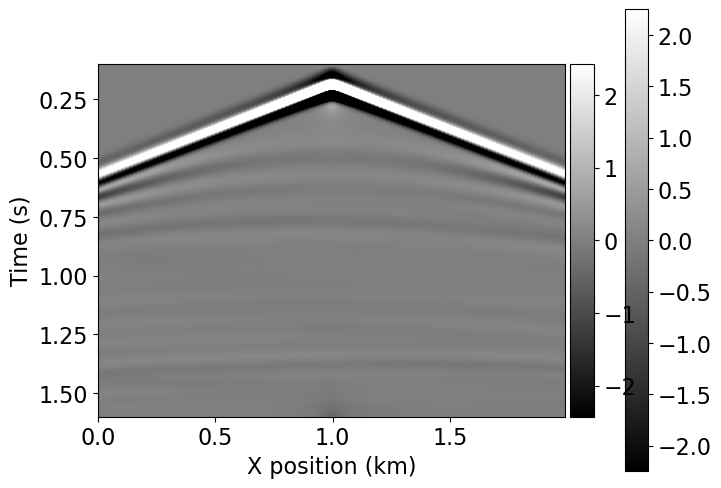

In [46]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(recs1[0].data, model, t0, tn)

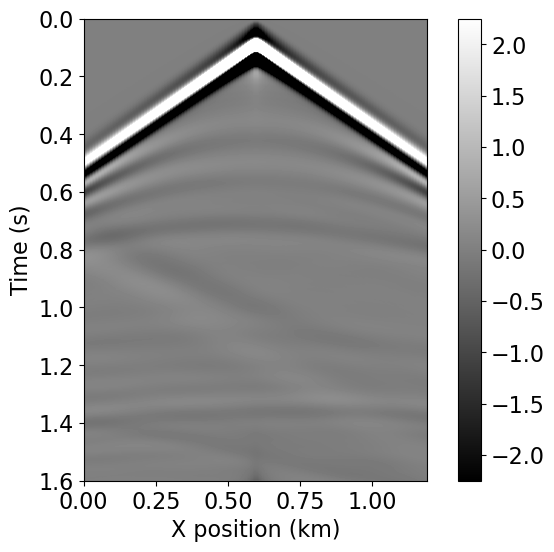

In [116]:
recs[0].data.shape

plt.imshow(recs1[0].data, extent=[0, 1.19, 1.6, 0], cmap="gray", vmin=-2.25, vmax=2.25)
plt.xlabel('X position (km)')
plt.ylabel('Time (s)')
plt.colorbar()
plt.show()

In [19]:
for i in range(len(recs1)):
    matrix = recs1[i].data
    # Menyimpan matriks ke file txt
    a = str(i)
    with open(a + "CSGFirst" + ".txt", "w") as file:
        for row in matrix:
            file.write(" ".join(map(str, row)) + "\n")


In [117]:
recs2 = []
for i in range(len(recs)):
    rec = Receiver(name='rec', grid=model.grid, time_range=geometrys[0].time_axis, coordinates=geometrys[0].rec_positions)
    rec.data[:] = recs[i].data[:] - recs1[i].data[:]
    recs2.append(rec)

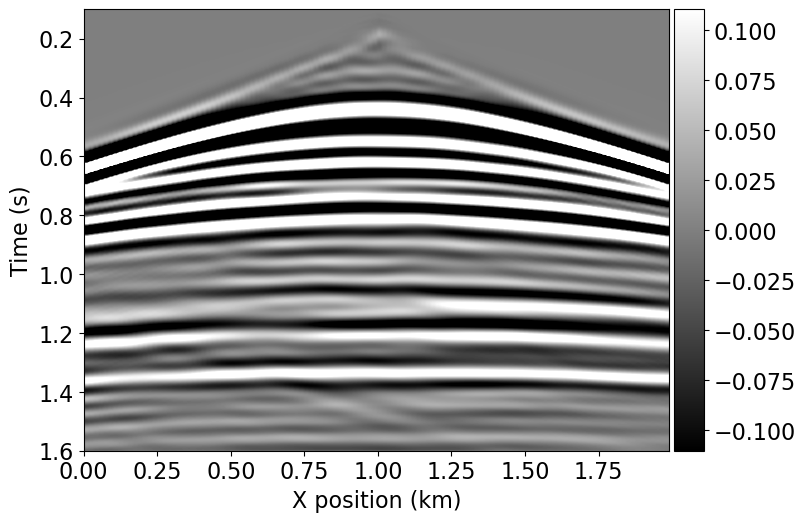

In [88]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(recs2[10].data, model, t0, tn)

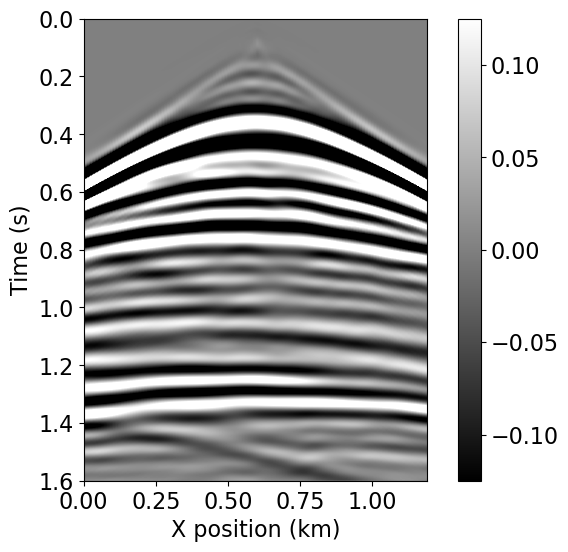

In [118]:
recs[0].data.shape

plt.imshow(recs2[0].data, extent=[0, 1.19, 1.6, 0], cmap="gray", vmin=-0.125, vmax=0.125)
plt.xlabel('X position (km)')
plt.ylabel('Time (s)')
plt.colorbar()
plt.show()

In [25]:
for i in range(len(recs2)):
    matrix = recs2[i].data
    # Menyimpan matriks ke file txt
    a = str(i)
    with open(a + "CSGRef" + ".txt", "w") as file:
        for row in matrix:
            file.write(" ".join(map(str, row)) + "\n")


In [21]:
rec1.data.shape

NameError: name 'rec1' is not defined

In [22]:
print(dt)

1.297


In [23]:
shotpoints = np.arange(1000, 1000+nshots)
receiver_x = np.linspace(615, 1415, nshots)
receiver_y = np.zeros(nshots)
receiver_z = np.ones(nshots)*20

print(shotpoints)

[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010]


In [24]:
n_receiver_x = []
for i in range(nshots):
    receiver_x = np.linspace(10+i*80, 1200+i*80, nreceivers)
    n_receiver_x.append(receiver_x)
n_receiver_x = np.array(n_receiver_x)

n_receiver_x.shape

(11, 120)

In [25]:
import numpy as np
from obspy.io.segy.segy import SEGYFile
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader, SEGYTrace


recs1 = []
for j in range(nshots):
    rec1 = []
    for i in range(nreceivers):
        rec1.append(recs[j].data[:,i])
    rec1 = np.array(rec1)
    dt = dt
    recs1.append(rec1)
    
shotpoints = np.arange(1000, 1000+nshots)
n_receiver_x = []
for i in range(nshots):
    receiver_x = np.linspace(10+i*80, 1200+i*80, nreceivers)
    n_receiver_x.append(receiver_x)
n_receiver_x = np.array(n_receiver_x)
receiver_y = np.zeros(nreceivers)
receiver_z = np.ones(nreceivers)*-10
    

# === 2. Buat file SEG-Y ===
segy = SEGYFile()
segy.binary_file_header = SEGYBinaryFileHeader()
segy.binary_file_header.sample_interval = int(dt * 1e6)  # Dalam mikrodetik
segy.binary_file_header.number_of_samples_per_trace = 1929
segy.binary_file_header.data_sample_format_code = 5  # FLOAT32 menggunakan kode numerik 5
segy.binary_file_header.implementation_code = 1  # Kode implementasi
segy.binary_file_header.number_of_trace_headers = 40  # Jumlah header per jejak
segy.binary_file_header.sorting_code = 1  # Kode pengurutan

# Tambahkan trace ke file SEG-Y
for j in range (nshots):
    for i, trace_data in enumerate(recs1[j]):  # Iterasi per geophone
        trace = SEGYTrace()
        trace.data = trace_data.astype(np.float32)  # Data harus float32
        trace.header.trace_sequence_number_within_line = int(i + 1)
        trace.header.receiver_point_number = shotpoints[j] + i
        trace.header.number_of_samples_in_this_trace = int(1929)
        trace.header.sample_interval_in_microseconds = int(dt * 1e6)
        trace.header.source_point_number = int(shotpoints[j])
        trace.header.receiver_group_elevation = int(receiver_z[i])
        trace.header.group_coordinate_x = int(n_receiver_x[j][i])
        trace.header.group_coordinate_y = int(receiver_y[i])
        trace.header.source_depth_below_surface = int(-20)
        trace.header.source_coordinate_x = (605 + (shotpoints[j] - 1000)*80)
        trace.header.source_coordinate_y = int(0)
        
        segy.traces.append(trace)
# === 3. Simpan file SEG-Y ===
segy.write("tes-splitspread2.sgy", data_encoding=5)
print("File SEG-Y berhasil dibuat: tes-splitspread2.sgy")

File SEG-Y berhasil dibuat: tes-splitspread2.sgy


In [26]:
from obspy.io.segy.segy import _read_segy

segy = _read_segy("tes-splitspread2.sgy")
for trace in segy.traces[:5]:  # Cek 5 trace pertama
    #print(f"Nshot: {trace.header.receiver_point_number}")
    print(f"Shot X: {trace.header.source_coordinate_x}")
    print(f"Shot Y: {trace.header.source_coordinate_y}")
    print(f"Elevation: {trace.header.source_depth_below_surface}")
    print(f"Receiver X: {trace.header.group_coordinate_x}")
    print(f"Receiver Y: {trace.header.group_coordinate_y}")
    print(f"Elevation: {trace.header.receiver_group_elevation}")
    


Shot X: 605
Shot Y: 0
Elevation: -20
Receiver X: 10
Receiver Y: 0
Elevation: -10
Shot X: 605
Shot Y: 0
Elevation: -20
Receiver X: 20
Receiver Y: 0
Elevation: -10
Shot X: 605
Shot Y: 0
Elevation: -20
Receiver X: 30
Receiver Y: 0
Elevation: -10
Shot X: 605
Shot Y: 0
Elevation: -20
Receiver X: 40
Receiver Y: 0
Elevation: -10
Shot X: 605
Shot Y: 0
Elevation: -20
Receiver X: 50
Receiver Y: 0
Elevation: -10


In [27]:
R = rec.data[:]
print(R.shape)

(1929, 120)


In [28]:
for i, trace_data in enumerate(rec1):  # Iterasi per geophone
    print(f"Data ke-{i} : {trace_data}")

Data ke-0 : [ 0.          0.          0.         ... -0.03646934 -0.03674013
  0.        ]
Data ke-1 : [ 0.          0.          0.         ... -0.03672557 -0.03682954
  0.        ]
Data ke-2 : [ 0.          0.          0.         ... -0.03668926 -0.03664611
  0.        ]
Data ke-3 : [ 0.          0.          0.         ... -0.03657563 -0.03636024
  0.        ]
Data ke-4 : [ 0.          0.          0.         ... -0.03601274 -0.03567624
  0.        ]
Data ke-5 : [ 0.          0.          0.         ... -0.035442   -0.03502208
  0.        ]
Data ke-6 : [ 0.          0.          0.         ... -0.03442752 -0.03389568
  0.        ]
Data ke-7 : [ 0.          0.          0.         ... -0.03342312 -0.03292328
  0.        ]
Data ke-8 : [ 0.          0.          0.         ... -0.03213527 -0.03152487
  0.        ]
Data ke-9 : [ 0.          0.          0.         ... -0.03083342 -0.03035271
  0.        ]
Data ke-10 : [ 0.          0.          0.         ... -0.02950499 -0.02893292
  0.        

In [29]:
from obspy.io.segy.segy import _read_segy

# === 1. Baca file SEG-Y ===
segy_file = _read_segy("tes1.sgy")

# === 2. Iterasi melalui setiap trace ===
for i, trace in enumerate(segy_file.traces):
    # Header trace
    header = trace.header
    # Data trace sebagai array NumPy
    data = trace.data
    
    # Cetak informasi header
    print(f"Trace {i + 1}:")
    #print(f"  Receiver Point Number: {header.receiver_point_number}")
    #print(f"  Number of Samples: {header.number_of_samples_in_this_trace}")
    #print(f"  Sample Interval (μs): {header.sample_interval_in_microseconds}")
    print(f"  First 10 Samples: {data[:]}\n")

# === 3. Jika ingin mengakses semua data sekaligus ===
# Misalnya, array 2D dengan dimensi (n_samples, n_geophones)
all_traces = [trace.data for trace in segy_file.traces]
data_matrix = np.array(all_traces).T  # (n_samples, n_geophones)


Trace 1:
  First 10 Samples: [ 0.          0.         -0.00449378 ...  0.03236292  0.03083626
  0.        ]

Trace 2:
  First 10 Samples: [0.         0.         0.         ... 0.03167843 0.02999101 0.        ]

Trace 3:
  First 10 Samples: [0.         0.         0.         ... 0.03063364 0.02881164 0.        ]

Trace 4:
  First 10 Samples: [0.         0.         0.         ... 0.02912017 0.02716277 0.        ]

Trace 5:
  First 10 Samples: [0.         0.         0.         ... 0.02660868 0.02449033 0.        ]

Trace 6:
  First 10 Samples: [0.         0.         0.         ... 0.02278691 0.02054023 0.        ]

Trace 7:
  First 10 Samples: [0.         0.         0.         ... 0.01781711 0.01555425 0.        ]

Trace 8:
  First 10 Samples: [0.         0.         0.         ... 0.01245573 0.0103686  0.        ]

Trace 9:
  First 10 Samples: [0.         0.         0.         ... 0.00754259 0.00573452 0.        ]

Trace 10:
  First 10 Samples: [0.         0.         0.         ... 0.00311

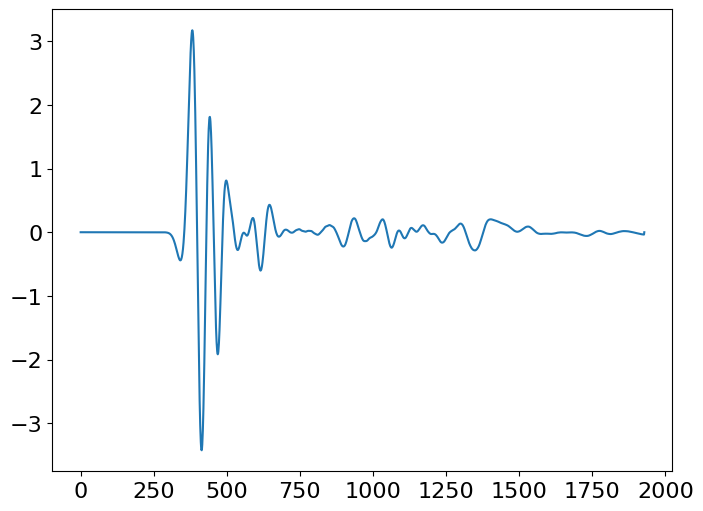

In [30]:
plt.plot(rec.data[:,0])
plt.show()

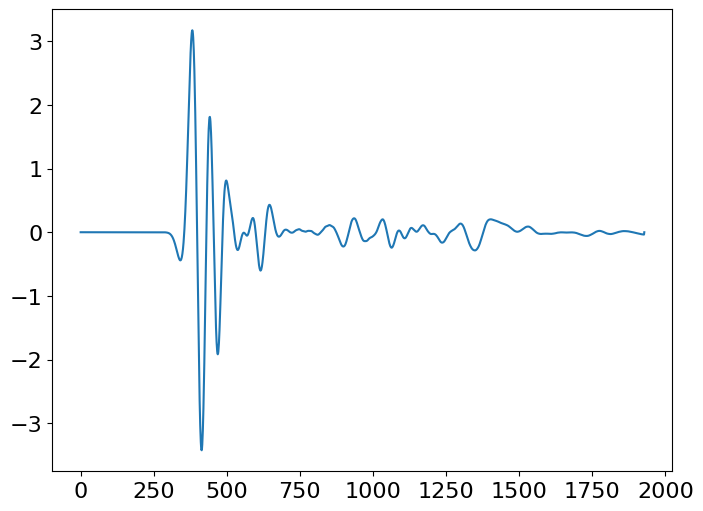

In [31]:

plt.plot(rec1[0,:])